# 📰 FNSPID News Data Analysis

This notebook **derives key metrics** and **creates visualizations** based on the **FNSPID news dataset**.  
It aims to provide clear insights into the data’s structure, trends, and underlying patterns.

In [1]:
import polars as pl
import re
from wordcloud import STOPWORDS, WordCloud
import matplotlib.pyplot as plt
import hvplot.polars

In [104]:
df = pl.read_csv("data/merged/ret_iti_news.csv")
df = df.unique()

In [88]:
df.filter(pl.col("Article_title").is_not_null())

ITI(13D),ITI(impatient),ITI(patient),ITI(insider),ITI(short),date,permco,ret,prc,vol,on_rdq,vol_missing_flag,comnam,Article_title
f64,f64,f64,f64,f64,str,i64,f64,f64,f64,i64,i64,str,str
0.501994,0.469929,0.228509,0.599906,0.4397699,"""2017-01-11""",51547,0.013199,180.39999,195109.0,0,0,"""ALLEGIANT TRAVEL CO""","""7 Biggest Price Target Changes…"
0.2526733,0.4514005,0.210055,0.8338675,0.4892263,"""2015-04-14""",21949,-0.012621,67.28,3.813823e6,0,0,"""T J X COMPANIES INC NEW""","""Big Retail Stocks: Can Lululem…"
0.679938,0.6186301,0.22243,0.428865,0.42316,"""2014-09-23""",37176,-0.013542,9.47,7.546707e6,0,0,"""ON SEMICONDUCTOR CORP""","""Analog Devices"""
0.17887,0.443992,0.051902,0.378139,0.357802,"""2015-06-05""",4655,0.001572,127.43,498187.0,0,0,"""UNIVERSAL HEALTH SERVICES INC""","""Goldman Sachs Initiates Univer…"
0.409524,0.457471,0.145514,0.4470228,0.3668775,"""2015-10-19""",20473,0.001937,67.25,2.384355e6,0,0,"""COLGATE PALMOLIVE CO""","""Why I Choose To Reinvest My Di…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.286878,0.493376,0.3933,0.6680698,0.5023937,"""2013-07-01""",323,0.016985,33.53,630700.0,0,0,"""ACTUANT CORP""","""Bear of the Day: Actuant (ATU)…"
0.7407668,0.789808,0.34891,0.800777,0.5878775,"""2014-07-31""",51992,-0.186957,5.61,3.2461356e7,0,0,"""GLU MOBILE INC""","""Markets Tumble; Kellogg Lowers…"
0.355443,0.3894696,0.103078,0.5451818,0.3808993,"""2010-10-06""",21102,0.00759,37.17,4.9841e6,0,0,"""LILLY ELI & CO""","""Eli Lilly's Core Product Trend…"


## Headline Distribution Analysis 

How is the FNSPID dataset distributed ? 

In [22]:
percentage = df['Article_title'].is_not_null().sum() / df.shape[0] * 100
print(f"Percentage of timestamps with articles: {percentage:.2f}%")

Percentage of timestamps with articles: 15.40%


In [23]:
df = df.with_columns([
    df['date'].str.slice(0, 4).cast(pl.Int32).alias('year')
])

yearly_counts = df.group_by('year').agg(pl.col('Article_title').is_not_null().sum().alias('count_with_headlines')).sort('year')

In [24]:
yearly_counts.hvplot.bar(
    x="year",
    y="count_with_headlines",
    title="Yearly Headline Counts",
    xlabel="Year",
    ylabel="Number of Headlines",
    width=700,
    height=400,
    legend="top_right"
)

:Bars   [year]   (count_with_headlines)

In [25]:
def process_text(articles, extra_stopwords=None):

    text = ' '.join(articles.to_series())

    text = re.sub(r'[^A-Za-z\s]', '', text)

    text = text.lower()

    stopwords = set(STOPWORDS).union(extra_stopwords) if extra_stopwords else set(STOPWORDS)
    text = ' '.join(word for word in text.split() if word not in stopwords)

    return text

Text(0.5, 1.0, 'Company News Word Cloud')

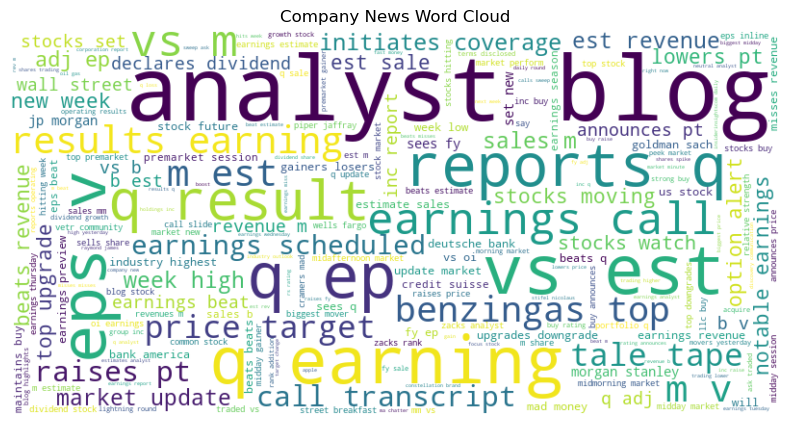

In [26]:
articles = df.select(pl.col("Article_title")).drop_nulls()
text_processed = process_text(articles)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_processed)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Company News Word Cloud")

## FINBERT Embedding Behaviour on Headlines

We examine how **FINBERT embeddings** structure our headline space

In [27]:
df_sentiment = pl.read_csv("data/preprocessed/financial_sentiment_analysis.csv")

In [33]:
df_sentiment = df_sentiment.with_columns([
    (pl.col('Positive') - pl.col('Negative')).alias('sentiment_score')
]).unique()

In [34]:
df_sentiment = df_sentiment.with_columns([
    df_sentiment['date'].str.slice(0, 4).cast(pl.Int32).alias('year')
])

In [35]:
df_sentiment.group_by('year').agg(pl.col('sentiment_score').mean()).sort('year').hvplot.line(
    x="year",
    y="sentiment_score",
    title="Average Yearly Sentiment Score",
    xlabel="Year",
    ylabel="Average Sentiment Score",
    width=700,
    height=400,
    legend="top_right"
)

:Curve   [year]   (sentiment_score)

## Headline Distribution Analysis - Constellation Brands

In this section, we explore how the **distribution of news headlines** related to *Constellation Brands* differs between **ITI** and **non-ITI** articles.


In [ ]:
import polars as pl

# --- Parameters ---
permco_id   = 1015 # Constellation Brands Inc
high_thr    = 0.8   
low_thr     = 0.1   
window_days = 7     


company = (
    df
    .filter((pl.col("permco") == permco_id))
    .select(["date", "Article_title", "ITI(13D)"])
    .with_columns(
        pl.col("date").str.to_datetime().dt.date().alias("date")  
    )
)

iti_events = (
    company
    .filter(pl.col("ITI(13D)") > high_thr)
    .select(pl.col("date").alias("event_date"))
    .unique()
)

non_iti_events = (
    company
    .filter(pl.col("ITI(13D)") < low_thr)
    .select(pl.col("date").alias("event_date"))
    .unique()
)


def build_window_calendar(events: pl.DataFrame, days: int) -> pl.DataFrame:
    return (
        events
        .with_columns([
            (pl.col("event_date") - pl.duration(days=days)).alias("start"),
            (pl.col("event_date")).alias("end"),
        ])
        .with_columns(
            pl.date_ranges(pl.col("start"), pl.col("end"), interval="1d").alias("window_dates")
        )
        .select(pl.col("window_dates"))
        .explode("window_dates")
        .select(pl.col("window_dates").alias("date"))
        .unique()  
    )

calendar_iti     = build_window_calendar(iti_events, window_days)
calendar_non_iti = build_window_calendar(non_iti_events, window_days)


articles_in_iti_window = (
    company.join(calendar_iti, on="date", how="inner")
           .unique(subset=["date", "Article_title"])   # use article_id if available
           .sort("date")
)

articles_in_non_iti_window_all = (
    company.join(calendar_non_iti, on="date", how="inner")
           .unique(subset=["date", "Article_title"])
           .sort("date")
)

articles_in_non_iti_window = (
    articles_in_non_iti_window_all.join(
        articles_in_iti_window.select("date", "Article_title"),
        on=["date", "Article_title"],
        how="anti"
    )
)

iti_titles     = articles_in_iti_window.select("Article_title").drop_nulls()
non_iti_titles = articles_in_non_iti_window.select("Article_title").drop_nulls()

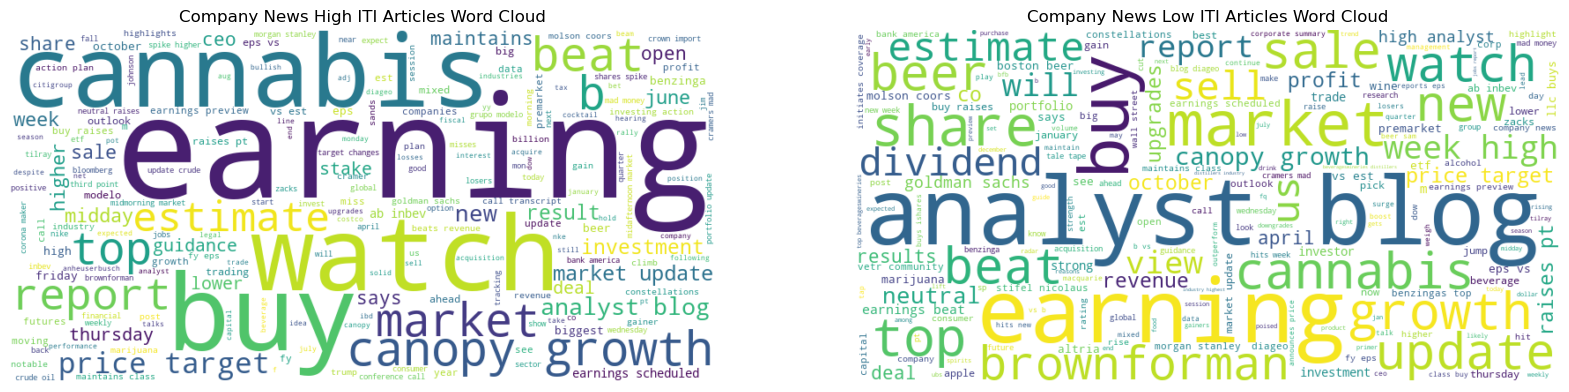

In [32]:
text_iti = process_text(iti_titles, extra_stopwords={"constellation", "brands", "stock", "stocks", "inc", "stz", 'q'})
text_not_iti = process_text(non_iti_titles, extra_stopwords={"constellation", "brands", "stock", "stocks", "inc", "stz", 'q'})


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_iti)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title("Company News High ITI Articles Word Cloud")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_not_iti)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title("Company News Low ITI Articles Word Cloud")

plt.show()

## Relationship Between News Date and ITI

In this section, we examine the **temporal relationship** between the publication date of news articles and the **Information Trading Intensity (ITI)**.



In [59]:
df

ITI(13D),ITI(impatient),ITI(patient),ITI(insider),ITI(short),date,permco,ret,prc,vol,on_rdq,vol_missing_flag,comnam,Article_title,year,ITI_MA5,ITI_MA7,return_next_5d
f64,f64,f64,f64,f64,str,i64,f64,f64,f64,i64,i64,str,str,i32,f64,f64,f64
0.030262,0.459814,0.022259,0.4647041,0.302864,"""2010-08-04""",37,0.003008,6.67,37901.0,0,0,"""ACETO CORP""","""Top 4 NASDAQ Stocks In The Hea…",2010,0.222197,0.112686,0.179151
0.1824342,0.3157569,0.202495,0.621768,0.429854,"""2010-09-10""",37,0.062295,6.48,341271.0,1,0,"""ACETO CORP""","""Stocks To Watch For September …",2010,0.217638,0.246769,0.12503
0.1824342,0.3157569,0.202495,0.621768,0.429854,"""2010-09-10""",37,0.062295,6.48,341271.0,1,0,"""ACETO CORP""","""Earnings Scheduled For Septemb…",2010,0.264511,0.206968,0.040784
0.481816,0.571877,0.312368,0.343383,0.380989,"""2010-09-13""",37,-0.016975,6.37,220488.0,0,0,"""ACETO CORP""","""Aceto - Upgrades & Downgrades""",2010,0.321199,0.247186,0.059121
0.509262,0.502513,0.515301,0.7607654,0.432274,"""2010-09-28""",37,0.035768,6.95,169539.0,0,0,"""ACETO CORP""","""A Peek Into The Market Before …",2010,0.38379,0.299689,0.040723
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.252577,0.324294,0.040632,0.508977,0.341612,"""2019-07-29""",56668,-0.021584,48.05,4.219839e6,0,0,"""DOW INC""","""Global Crop Protection Chemica…",2019,0.316994,0.521338,-0.10792
0.252577,0.324294,0.040632,0.508977,0.341612,"""2019-07-29""",56668,-0.021584,48.05,4.219839e6,0,0,"""DOW INC""","""Susquehanna Downgrades Dow to …",2019,0.266024,0.476544,-0.10792
0.252577,0.324294,0.040632,0.508977,0.341612,"""2019-07-29""",56668,-0.021584,48.05,4.219839e6,0,0,"""DOW INC""","""10 Biggest Price Target Change…",2019,0.524369,0.431751,-0.079052


In [63]:
analysis_df = df.join(df_sentiment, left_on = ['date', 'Article_title'],right_on=['date', 'Headline'], how='inner')

In [64]:
analysis_df = (
    analysis_df .sort(["permco", "date"])
      .with_columns(
          pl.col("ITI(13D)")
          .rolling_mean(window_size=7)
          .over("permco")               
          .alias("ITI_MA7")
      )
)
analysis_df  = analysis_df .drop_nulls(subset=["ITI_MA7"])

In [65]:
analysis_df  = analysis_df .with_columns(
    pl.col("ret")
    .rolling_sum(window_size=5)
    .shift(-5)                    
    .over("permco")              
    .alias("return_next_5d")
)
analysis_df  = analysis_df .drop_nulls()

In [66]:
analysis_df  = analysis_df .filter(pl.col('Article_title').is_not_null())

In [70]:
import statsmodels.formula.api as smf

model1 = smf.ols("return_next_5d ~ sentiment_score*ITI_MA7", data=analysis_df.to_pandas()).fit()
model2 = smf.ols("return_next_5d ~ sentiment_score + ITI_MA7", data=analysis_df.to_pandas()).fit()
model3 = smf.ols("return_next_5d ~ sentiment_score", data=analysis_df.to_pandas()).fit()

In [ ]:
print(model1.summary())



                            OLS Regression Results                            
Dep. Variable:         return_next_5d   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7478.
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:11:04   Log-Likelihood:            -5.4105e+05
No. Observations:             3178861   AIC:                         1.082e+06
Df Residuals:                 3178857   BIC:                         1.082e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [72]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         return_next_5d   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7408.
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:11:11   Log-Likelihood:            -5.4484e+05
No. Observations:             3178861   AIC:                         1.090e+06
Df Residuals:                 3178858   BIC:                         1.090e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0068      0.000     

In [73]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:         return_next_5d   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                 1.452e+04
Date:                Sat, 01 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:11:18   Log-Likelihood:            -5.4499e+05
No. Observations:             3178861   AIC:                         1.090e+06
Df Residuals:                 3178859   BIC:                         1.090e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0013      0.000     

In [ ]:
import polars as pl


df = df.with_columns(pl.col("date").str.to_datetime()).sort(["permco", "date"])


news_dates = (
    df.filter(pl.col("Article_title").is_not_null())
      .select(["permco", pl.col("date").alias("news_date")])
      .unique()
)

# Build ±10-day windows around each news_date
window_before = 10
window_after = 2
calendar = (
    news_dates
    .with_columns([
        (pl.col("news_date") - pl.duration(days=window_before)).alias("start"),
        (pl.col("news_date") + pl.duration(days=window_after)).alias("end")
    ])
    .with_columns(
        pl.date_ranges(pl.col("start"), pl.col("end"), interval="1d").alias("window_dates")
    )
    .select(["permco", "news_date", "window_dates"])
    .explode("window_dates")
    .rename({"window_dates": "date"})
)

# Join the ITI data to get ITI values around each news date
calendar = calendar.with_columns(pl.col("date").dt.date().alias("date"))
df = df.with_columns(pl.col("date").dt.date().alias("date"))

iti_around_news = calendar.join(
    df.select(["permco", "date", "ITI(13D)", "Article_title"]),
    on=["permco", "date"],
    how="left"
)
iti_around_news = iti_around_news.sort(["permco", "news_date", "date"]).drop_nulls(subset=["ITI(13D)"])

iti_around_news = iti_around_news.with_columns(
    (pl.col("date") - pl.col("news_date"))
    .dt.total_days()              
    .cast(pl.Int32)
    .alias("days_from_news")
)

iti_pattern = (
    iti_around_news
    .group_by("days_from_news")
    .agg(pl.col("ITI(13D)").mean().alias("avg_ITI"))
    .sort("days_from_news")
)

In [119]:
iti_pattern.hvplot.line(
    x="days_from_news", y="avg_ITI",
    title="Average ITI Evolution Around News",
    xlabel="Days from News", ylabel="Mean ITI(13D)",
    width=700, height=400
)

:Curve   [days_from_news]   (avg_ITI)

In [133]:
pre_window = (-7, -1)
post_window = (1, 2)

iti_change = (
    iti_around_news
    .filter(pl.col("days_from_news").is_between(pre_window[0], post_window[1]))
    .group_by(["permco", "news_date", "Article_title"])
    .agg([
        pl.col("ITI(13D)")
          .filter(pl.col("days_from_news").is_between(*pre_window))
          .mean()
          .alias("ITI_before"),
        pl.col("ITI(13D)")
          .filter(pl.col("days_from_news").is_between(*post_window))
          .mean()
          .alias("ITI_after")
    ])
    .with_columns(
        (pl.col("ITI_after") - pl.col("ITI_before")).alias("ITI_change")
    )
    .sort("ITI_change", descending=True)
)

In [139]:
top_rising = iti_change.drop_nulls().top_k(10, by="ITI_change")

In [166]:
for row in top_rising.iter_rows():
    print(f"Permco: {row[0]}, News Date: {row[1]}, Article Title: {row[2]}")
    print(f"ITI Change: {row[-1]:.4f} (Before: {row[3]:.4f}, After: {row[4]:.4f})")
    print("-" * 80)

Permco: 54904, News Date: 2015-10-14 00:00:00, Article Title: After Hours Gainers / Losers
ITI Change: 0.7666 (Before: 0.1442, After: 0.9108)
--------------------------------------------------------------------------------
Permco: 21057, News Date: 2016-07-27 00:00:00, Article Title: The Vetr community has upgraded $KEX to 3-Stars.
ITI Change: 0.7111 (Before: 0.2279, After: 0.9390)
--------------------------------------------------------------------------------
Permco: 21057, News Date: 2016-07-26 00:00:00, Article Title: The Vetr community has upgraded $KEX to 3-Stars.
ITI Change: 0.7111 (Before: 0.2279, After: 0.9390)
--------------------------------------------------------------------------------
Permco: 31196, News Date: 2016-11-23 00:00:00, Article Title: 5—-Week Company Lows
ITI Change: 0.7090 (Before: 0.1626, After: 0.8716)
--------------------------------------------------------------------------------
Permco: 21019, News Date: 2012-07-18 00:00:00, Article Title: Consumer Cycli

In [ ]:
news_window_dates = calendar.select(["permco", "date"]).unique()

iti_near_news = df.join(news_window_dates, on=["permco", "date"], how="inner")


iti_no_news = df.join(news_window_dates, on=["permco", "date"], how="anti")

In [169]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(
    iti_near_news["ITI(13D)"].to_numpy(),
    iti_no_news["ITI(13D)"].to_numpy(),
    equal_var=False
)
print(f"T-statistic={t_stat:.3f}, p-value={p_val:.3f}")

T-statistic=218.234, p-value=0.000


In [170]:
mean_near  = iti_near_news["ITI(13D)"].mean()
mean_no    = iti_no_news["ITI(13D)"].mean()
diff = mean_near - mean_no
print(f"Mean difference = {diff:.4f}")

Mean difference = 0.0302


In [178]:
iti_near_news.hvplot.kde(y="ITI(13D)", label="Near News") * \
iti_no_news.hvplot.kde(y="ITI(13D)", label="No News")

:Overlay
   .Distribution.Near_News :Distribution   [ITI(13D)]   (Density)
   .Distribution.No_News   :Distribution   [ITI(13D)]   (Density)